## Import libraries


In [0]:
import matplotlib.pyplot as plt
import numpy as np

import torch
from torch import nn, optim
import torch.nn.functional as F
from torchvision import datasets, transforms

%matplotlib inline

## Helper functions for Visualization

In [0]:
def imshow(image, ax=None, title=None, normalize=True):
    """Imshow for Tensor."""
    if ax is None:
        fig, ax = plt.subplots()
    image = image.numpy().transpose((1, 2, 0))

    if normalize:
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = std * image + mean
        image = np.clip(image, 0, 1)

    ax.imshow(image)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_visible(False)
    ax.tick_params(axis='both', length=0)
    ax.set_xticklabels('')
    ax.set_yticklabels('')

    return ax

In [0]:
def view_classify(img, ps):
    ''' Function for viewing an image and it's predicted classes.'''
    ps = ps.data.numpy().squeeze()

    fig, (ax1, ax2) = plt.subplots(figsize=(6,9), ncols=2)
    ax1.imshow(img.resize_(1, 28, 28).numpy().squeeze())
    ax1.axis('off')
    ax2.barh(np.arange(10), ps)
    ax2.set_aspect(0.1)
    ax2.set_yticks(np.arange(10))
    ax2.set_yticklabels(np.arange(10))
    ax2.set_title('Class Probability')
    ax2.set_xlim(0, 1.1)

    plt.tight_layout()

## Data Loading and Transformations

In [0]:
# Define a transform
transform = transforms.Compose([transforms.ToTensor(),
                               transforms.Normalize((0.5,), (0.5,)),
                              ])

In [0]:
# Load data
trainset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=True, transform=transform)
testset = datasets.MNIST('~/.pytorch/MNIST_data/', download=True, train=False, transform=transform)

# Define data loaders
trainloader = torch.utils.data.DataLoader(trainset, batch_size=64, shuffle=True)
testloader = torch.utils.data.DataLoader(testset, batch_size=64, shuffle=True)

label: 5


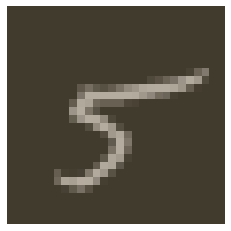

In [6]:
# Example Image
image, label = next(iter(trainloader))
imshow(image[0].view(1, 28, 28))
print('label: {}'.format(label[0].item()))

## Create Model

In [0]:
class Classifier(nn.Module):
    ''' Creates a Classifier model for MNIST dataset. '''
    def __init__(self):
        super().__init__()
        self.layer1 = nn.Linear(784, 128)
        self.layer2 = nn.Linear(128, 64)
        self.layer3 = nn.Linear(64, 10)

    def forward(self, x):
        #flattened input tensor
        x = x.view(x.shape[0], -1)

        x = F.relu(self.layer1(x))
        x = F.relu(self.layer2(x))
        x = F.log_softmax(self.layer3(x), dim=1)

        return x

## Training Process

In [0]:
# Define model, cost function and optimizer
model = Classifier()

cost = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001)

In [14]:
epochs = 10
    
train_losses, test_losses = [], []

for e in range(epochs):
    train_loss = 0
    for X, Y in trainloader:
        # train
        optimizer.zero_grad()
        # forward pass
        Y_hat = model.forward(X)  
        # backward pass 
        loss = cost(Y_hat, Y)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    else:
        # validate
        test_loss = 0
        test_acc = 0

        # Turn off gradients for validation, saves memory and computations
        with torch.no_grad():
            for X, Y in testloader:
                Y_hat = model.forward(X)
                test_loss += cost(Y_hat, Y)
                
                Y_hat = torch.exp(Y_hat)
                top_p, top_class = Y_hat.topk(1, dim=1)
                equals = top_class == Y.view(*top_class.shape)
                test_acc += torch.mean(equals.type(torch.FloatTensor))
    
    train_losses.append(train_loss/len(trainloader))
    test_losses.append(test_loss/len(testloader))

    print("Epoch: {}/{}.. ".format(e+1, epochs),
            "Training Loss: {:.3f}.. ".format(train_loss/len(trainloader)),
            "Test Loss: {:.3f}.. ".format(test_loss/len(testloader)),
            "Test Accuracy: {:.2f}%".format((test_acc/len(testloader))* 100))

Epoch: 1/10..  Training Loss: 2.204..  Test Loss: 2.084..  Test Accuracy: 49.59%
Epoch: 2/10..  Training Loss: 1.901..  Test Loss: 1.671..  Test Accuracy: 58.40%
Epoch: 3/10..  Training Loss: 1.438..  Test Loss: 1.202..  Test Accuracy: 72.42%
Epoch: 4/10..  Training Loss: 1.046..  Test Loss: 0.893..  Test Accuracy: 79.22%
Epoch: 5/10..  Training Loss: 0.805..  Test Loss: 0.710..  Test Accuracy: 82.80%
Epoch: 6/10..  Training Loss: 0.663..  Test Loss: 0.601..  Test Accuracy: 84.55%
Epoch: 7/10..  Training Loss: 0.576..  Test Loss: 0.533..  Test Accuracy: 86.01%
Epoch: 8/10..  Training Loss: 0.519..  Test Loss: 0.482..  Test Accuracy: 86.93%
Epoch: 9/10..  Training Loss: 0.479..  Test Loss: 0.450..  Test Accuracy: 87.72%
Epoch: 10/10..  Training Loss: 0.449..  Test Loss: 0.423..  Test Accuracy: 88.05%


## Visualization of Losses

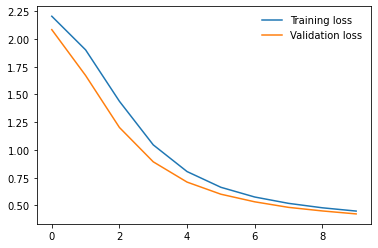

In [15]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)

## Predictions

In [0]:
def predict():
    '''Chooses a random Image from Testset and classifies it'''
    X, Y = next(iter(testloader))
    x = X[0]

    with torch.no_grad():
        y_hat = model.forward(x)
    
    y_hat = torch.exp(y_hat)
    view_classify(x.view(1, 28, 28), y_hat)

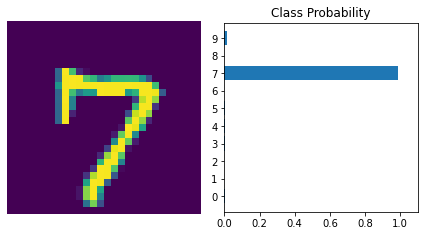

In [28]:
predict()